## Кейс 1. Преобразование признаков

Содержание:
* [Time Series "Потребление энергии"](#ts)
* [Экспоненциальное сглаживание](#er)
* [Оценка влияния глубины прогноза (h) в модели для сезонных изменений](#erh)

Определение характера ряда: (стационарный или нет, с трендом, с сезоном, с циклом):

а) Изменение температуры за окном.

В ряде можно выделить суточные (в основном), квартальные, годовые, эпохальные циклы. В течение нескольких лет проявляется сезонность. В рамках столетия можно выявить тренды на общее снижение/повышение температуры (в зависимости от локации). В частных случаях, напр. при наблюдении средней температуры в течение долгих лет (в зоне с постоянным климатом), данные могут быть стационарны .

б) Количество денег, которые тратят покупатели в интернет магазине.

Ряд может обладать выраженной цикличностью (больше покупок в выходные), сезонностью (местные праздники), иметь тренд (баланс между трендами популярности ассортимента/PR программой магазина/изменение покупательской способностью населения за определенный период времени). Для крупной компании, вышедшей на полную мощность в ряде случаев можно рассматривать её деятельность, как стационарный процесс.

в) Вес растущего котенка.

Вес растущего котенка подвержен трендовому влиянию (по логарифмической кривой). В частном случае, можно выявить циклические колебания в ускорении набора массы (при постоянном измерении в периоды сна и бодроствования). На прирост массы может влиять время года (что влияет на активности животного). Данный процесс не стационарный.

г) Прирост объема деревьев в лесу от времени (объема зеленой и древесной массы)

Процесс имеет аналогию с котенком, имея более четко выраженную сезонность. Тренд больше выражается, если рассматривать растущий лес, где больше молодых деревьев (или умирающий). Учитывая, что прирост биомассы зависит от количество питания, процесс роста леса может выйти на стационарный уровень на годовых данных.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import warnings
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import datetime

warnings.filterwarnings('ignore')
%matplotlib inline

## Time Series "Потребление энергии"
<left><a class="anchor" id="ts"></a><left>
Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [7]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

##### Визуализация данных

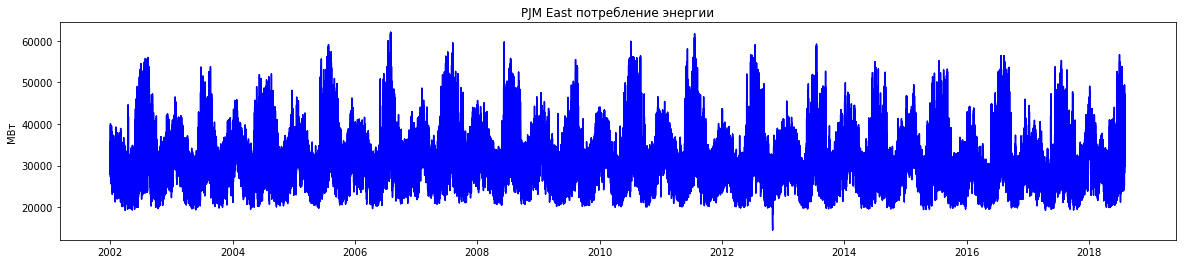

In [8]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

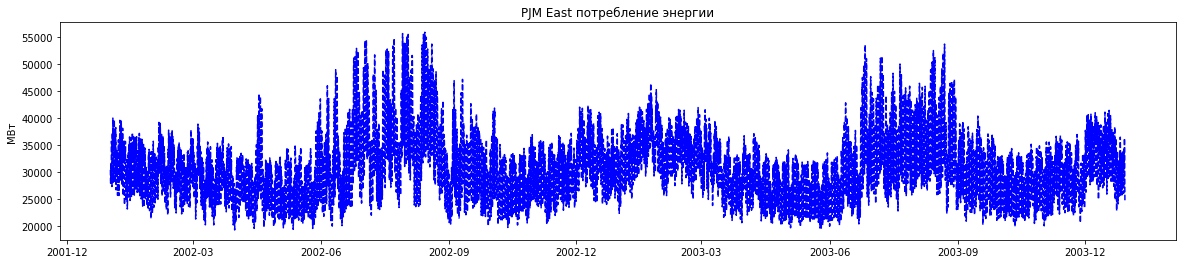

In [9]:
date_time = data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")

plt.figure(figsize =(20,4))
plt.plot(date_time.index[:24*7*104], date_time.values[:24*7*104], '--b')
plt.title('PJM East потребление энергии')
plt.ylabel ('МВт')
plt.show()

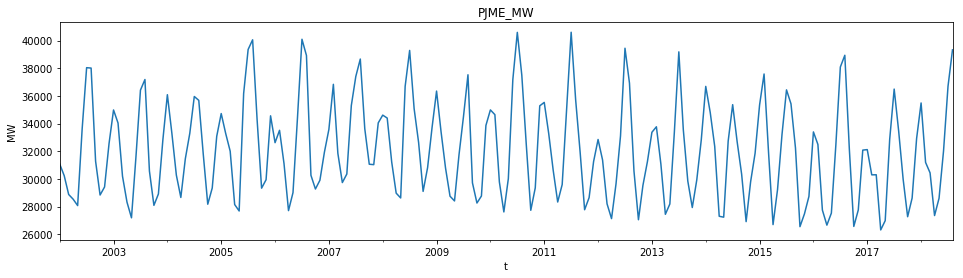

In [10]:
data_m = data.resample('M').mean()
data_m['PJME_MW'].plot(style='-', figsize=(16, 4), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

Можно проверить как ведут себя первые разности (x(t)-x(t-1)). Если ряд таких разностей стационарен, то можно гарантировать стационарность ряда после удаления основной его части

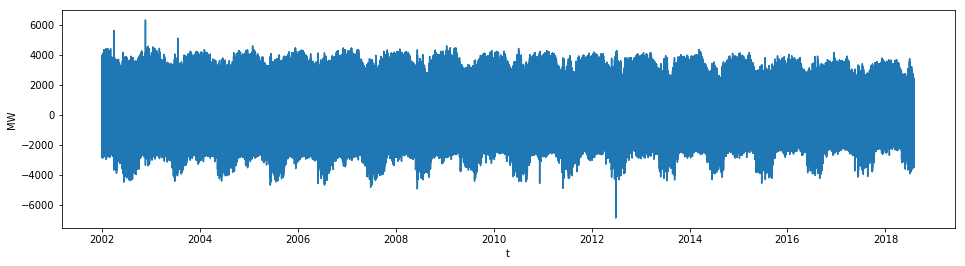

In [11]:
# Первые разности (x(t)-x(t-1))
sub1_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]
sub1_idx = data.iloc[:-1].index

plt.figure(figsize=(16,4))
plt.plot(sub1_idx, sub1_data)
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

In [12]:
# Тест Дики-Фуллера (ADF)
# regression='ctt' - анализировать на постоянные составляющие, линейные и квадратичные тренды. 
# Первый параметр должен содержать одномерный массив или Series

data_resampled = data.resample('M').mean()
DF_data = sm.tsa.stattools.adfuller(data_resampled['PJME_MW'].values,regression='ctt')
DF_data

(-2.577455591729604,
 0.5247860093676766,
 15,
 184,
 {'1%': -4.435220952056536,
  '5%': -3.86487409876613,
  '10%': -3.5733156719443473},
 3230.9060995689206)

Из результатов применения ADF следует: ряд потребление энергии имеет значение DF_data[0] = -2.57 значительно больше критического для 10% (-3.57), а значит с вероятностью большей 10% не стационарен (Нуль-гипотеза отклонена). Он не имеет тренда, но есть сезоны.

In [13]:
# Тест ADF на стационарность для различых семплов

samples = {'year': 'Y', 'month': 'M', 'week': 'W', 'day': 'D'}

for s in samples:
    data_resampled = data.resample(samples.get(s)).mean()
    DF_data = sm.tsa.stattools.adfuller(data_resampled['PJME_MW'].values,regression='ctt')
    print(f'{s}: {DF_data[1]}')

year: 0.9989573259007248
month: 0.5247860093676766
week: 3.1785518401434895e-22
day: 4.282974615240694e-11


In [14]:
# Тест ADF на первых разностях 

DF_data_sub1 = sm.tsa.stattools.adfuller(sub1_data,regression='ctt')
DF_data_sub1[1]

0.0

На основании этого теста ряд является интегрированным рядом. Лаги изменения потребления энергии стационарны на месячных данных.

Модель необходимо разделить на сезонность потребления энергии от стационарных колебаний вокруг этих компонент.

## Экспоненциальное сглаживание
<left><a class="anchor" id="er"></a><left>

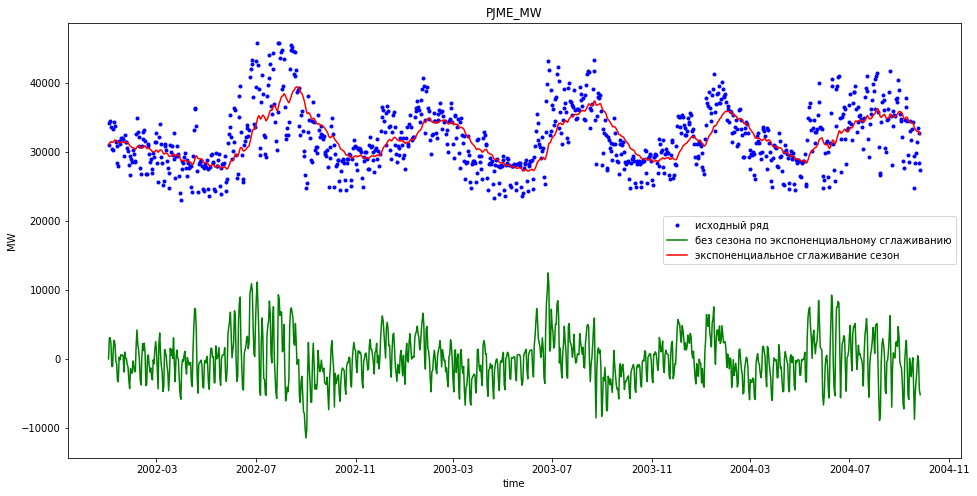

In [15]:
# Функция экспоненциальной средней

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

d_data=data.resample('D').mean()
idx_to = 1000 # Используются первые 1000 измерений

data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(16, 8))

plt.plot(d_data.index[:idx_to], d_data['PJME_MW'].values[:idx_to],
         '.b',
         label='исходный ряд')

plt.plot(d_data.index[:idx_to],d_data['PJME_MW'].values[:idx_to] - data_exp_1[:idx_to],
         color = 'green',
         label="без сезона по экспоненциальному сглаживанию")

plt.plot(d_data.index[:idx_to],data_exp_1[:idx_to],
         color = 'red',
         label="экспоненциальное сглаживание сезон")

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')
plt.show()

In [16]:
# Тест ADF для ряда после вычета из него сезонной составляющей (экспоненциального сглаживания)

data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) - data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.36536213856378,
 4.282974615351466e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Результат удаления сезонной составляющей для потребления энергии - явно стационарный ряд.

###  Оценка влияния глубины прогноза (h) в модели для сезонных изменений
<left><a class="anchor" id="erh"></a><left>

In [17]:
# Датафрейм для построения модели (экспоненциально сглаженные данные с дневным ресемплингом)

data_d=data.resample('D').mean()
b_ar_exp_1 = exponential_smoothing(data_d['PJME_MW'], alpha=0.08)
b_ar_exp_1 = pd.DataFrame(data = b_ar_exp_1, index = data_d.index)
df = pd.DataFrame(b_ar_exp_1) # Датасет с эксопненциальными средними

In [18]:
# Train test split

def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()


split_rate = 0.1 # Размер тестовой выборки, %

split_date = data.index[(int(len(data.index) * (1-split_rate)))]
train, test = split_data(df, split_date)

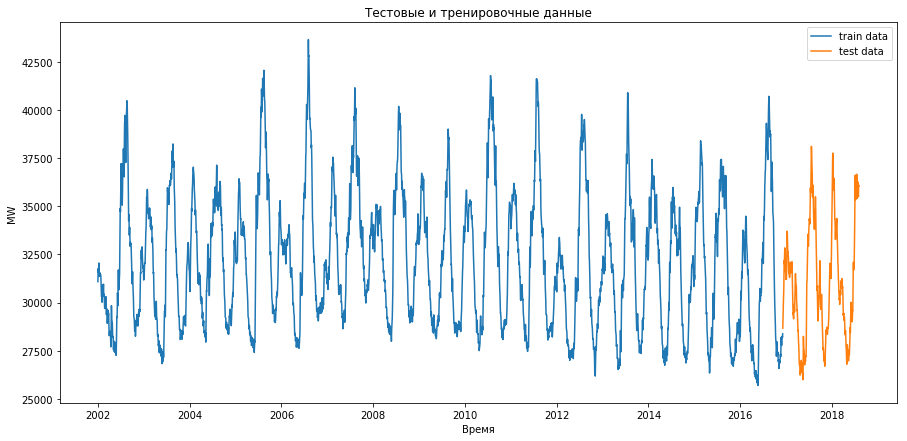

In [19]:
X_train = train.iloc[:-1,:]
y_train = train[df.columns[0]].values[1:]
X_test = test.iloc[:-1,:]
y_test = test[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(train.index.get_level_values('Date'),train[df.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'),test[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [20]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train) 
X_test_pred_gb = model_gb.predict(X_test)

In [22]:
# Метрика качества (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

0.8408414571946308

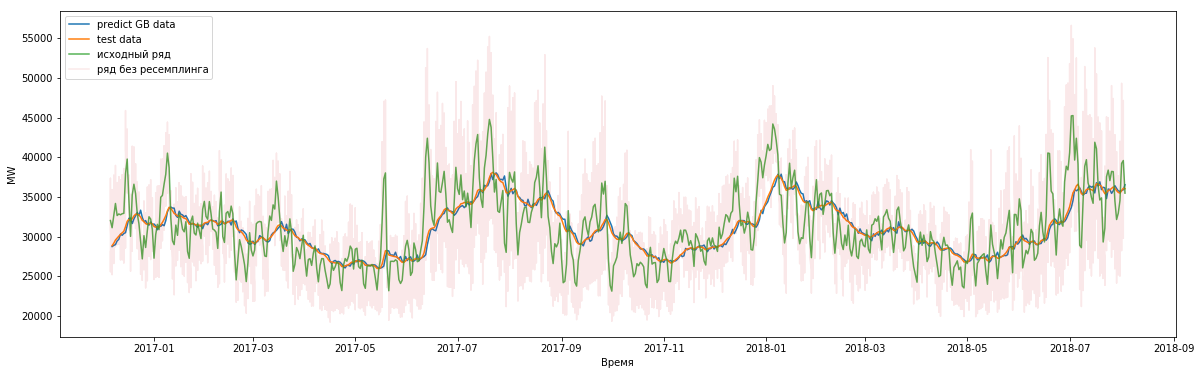

Ошибка градиентного бустинга :   0.8408414571946308 %


In [23]:
# Модель с горизонтом прогноза 1

day_after_splitting = split_date + datetime.timedelta(days=1)

plt.figure(figsize=( 20, 6 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[1:],y_test, label='test data')
plt.plot(data_d.loc[day_after_splitting:].index, data_d.loc[day_after_splitting:]['PJME_MW'], label='исходный ряд', alpha=0.8)
plt.plot(data.loc[day_after_splitting:].index, data.loc[day_after_splitting:]['PJME_MW'], label='ряд без ресемплинга', alpha=0.1)

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('Ошибка градиентного бустинга :  ', er_g, '%')

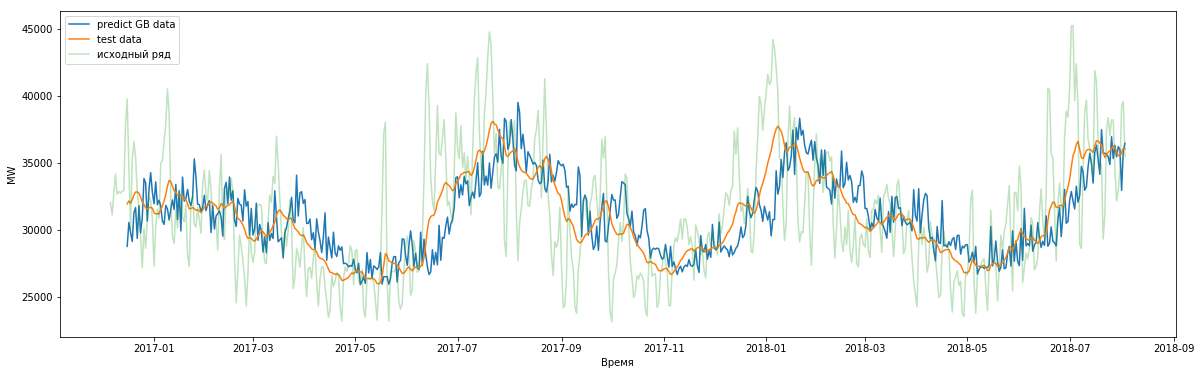

Ошибка градиентного бустинга :   4.679931199867917 %


In [24]:
# Модель с горизонтом прогноза 10

h=10

X_train = train.iloc[:-h,:]
y_train = train[df.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df.columns[0]].values[h:]

model_gb.fit(X_train, y_train ) 
X_test_pred_gb = model_gb.predict(X_test)

plt.figure(figsize=( 20, 6 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(data_d.loc[day_after_splitting:].index, data_d.loc[day_after_splitting:]['PJME_MW'], label='исходный ряд', alpha=0.3)

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('Ошибка градиентного бустинга :  ', er_g, '%')

In [36]:
errs = []

l1 = np.arange(1, 91)
l2 = np.array([100, 200, 300, 400, 500])
hh = np.append(l1, l2)

for i in range(len(hh)):
    X_train = train.iloc[:-hh[i],:]
    y_train = train[df.columns[0]].values[hh[i]:]
    X_test = test.iloc[:-hh[i],:]
    y_test = test[df.columns[0]].values[hh[i]:]
    
    model_gb.fit(X_train, y_train ) 
    X_test_pred_gb = model_gb.predict(X_test)
    
    er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)
    errs.append(er_g)
    if i%10 == 0:
        print(f'Ошибка градиентного бустинга при глубине {hh[i]}: {round(er_g, 2)} %')

Ошибка градиентного бустинга при глубине 1: 0.84 %
Ошибка градиентного бустинга при глубине 11: 4.93 %
Ошибка градиентного бустинга при глубине 21: 7.06 %
Ошибка градиентного бустинга при глубине 31: 8.71 %
Ошибка градиентного бустинга при глубине 41: 9.75 %
Ошибка градиентного бустинга при глубине 51: 10.09 %
Ошибка градиентного бустинга при глубине 61: 10.21 %
Ошибка градиентного бустинга при глубине 71: 9.86 %
Ошибка градиентного бустинга при глубине 81: 9.56 %
Ошибка градиентного бустинга при глубине 100: 9.38 %


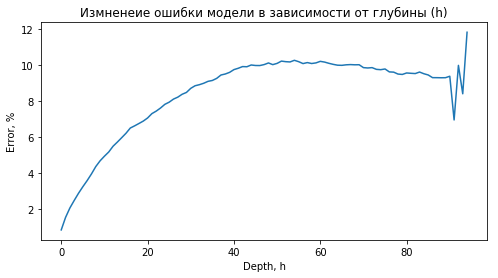

In [38]:
plt.figure(figsize=(8,4))
plt.plot(errs)
plt.xlabel('Depth, h')
plt.ylabel('Error, %')
plt.title('Измненеие ошибки модели в зависимости от глубины (h)')
plt.show()

Итог: 

Для временного ряда можно спрогнозировать изменение текущего значения на несколько шагов с достаточно высокой точностью. Долгосрочные прогнозы возможны для некоторых хорошо подготовленных рядов. При увеличении глубины прогноза ошибка растет.

На качество модели значительное влияние оказывает предварительное сглаживание данных, выделение нестационарных циклических изменений.

Настройка параметров зависит от характера временного ряда и наличия шумов.